In [1]:
import pandas as pd
import glob
import os

paths = [
    "resources/aime24/o3minilow-aime24-sprt-050010050949976",
    "resources/aime24/o3minilow-aime24-msprt-1e61e6005094994-3",
    "resources/aime24/o3minimedium-aime24-sprt-050010050949976",
    "resources/aime24/o3minimedium-aime24-msprt-1e61e6005094994",
    "resources/aime24/o3minihigh-aime24-sprt-050010050949976",
    "resources/aime24/o3minihigh-aime24-msprt-1e61e6005094994"
]

In [2]:
from consol.confident_solver import *

/Users/hyun-hwanjeong/miniforge3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
solver = ConfidentSolver(llm_model="o3-mini-low", confidence_model="msprt", output_schema="float")


In [35]:
from itertools import cycle
def _get_messages(msg):
    for x in msg:
        yield x

def _get_top_two_answers(total_outputs):
    total_ss = pd.Series(total_outputs).value_counts()
    two = total_ss.sort_values(ascending=False).head(2).to_list()
    while len(two) < 2:
        two += [0]
    return two[0], two[1]

def _determine_trials(solver, first, second, max_trials, current_trials):
    for trials in range(0, max_trials + 1):
        if first + trials == 0:
            continue
        if solver.confidence_model.test(first + trials, second):
            break
    if trials >= max_trials - current_trials:
        trials = max_trials - current_trials
    return trials

def _collect_raw_outputs(trials, func_msg):
    raw_outputs = []
    while len(raw_outputs) < trials:
        k = trials - len(raw_outputs)
        partial_raw_outputs = [next(func_msg) for i in range(k)]
        raw_outputs += partial_raw_outputs
    return raw_outputs


def invoke(solver, messages):
    num_turns = 0
    max_trials = solver.confidence_model.config.max_trials
    total_raw_outputs = []
    msg_func = _get_messages(messages)
    all_turns = []
    while True:
        # print(total_raw_outputs)
        first, second = _get_top_two_answers(total_raw_outputs)
        trials = _determine_trials(solver, first, second, max_trials, len(total_raw_outputs))
        if trials == 0:
            break
        raw_outputs = _collect_raw_outputs(trials, msg_func)
        num_turns += 1

        all_turns.append(len(raw_outputs))
        total_raw_outputs += raw_outputs
    
    assert None == next(msg_func, None)  # Print the last message

    assert len(all_turns) ==  num_turns
    return sum(all_turns) / len(all_turns)


In [36]:
 
solver = ConfidentSolver(llm_model="o3-mini-low", confidence_model="msprt", output_schema="float")

df = []
for path in paths:
    run = path.split("/")[-1]

    model = "msprt" if "msprt" in run else "sprt"
    solver = ConfidentSolver(llm_model="o3-mini-low", confidence_model=model, output_schema="float")
    path = os.path.join("../../..", path, "*.csv")
    result_files = glob.glob(path)
    solver = ConfidentSolver(llm_model="o3-mini-low", confidence_model="msprt", output_schema="float")
    total_turns = [invoke(solver, pd.read_csv(f, index_col=0).answer) for f in result_files]
    df.append(pd.DataFrame({
        "run": run,
        "model": model,
        "Generations Per Turn": total_turns
    }))

In [37]:
pd.concat(df).groupby(["run"]).agg({"Generations Per Turn": ["mean", "std"]})

Generations Per Turn          
                                                          mean       std
run                                                                     
o3minihigh-aime24-msprt-1e61e6005094994               2.877778  0.285953
o3minihigh-aime24-sprt-050010050949976                2.810000  0.344430
o3minilow-aime24-msprt-1e61e6005094994-3              2.584256  0.467133
o3minilow-aime24-sprt-050010050949976                 2.583836  0.415619
o3minimedium-aime24-msprt-1e61e6005094994             2.728611  0.448943
o3minimedium-aime24-sprt-050010050949976              2.729206  0.456345

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

/var/folders/7y/fy_b33wn4jjcvgnn60w2l_xc0000gn/T/ipykernel_42676/1083842516.py:19: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(


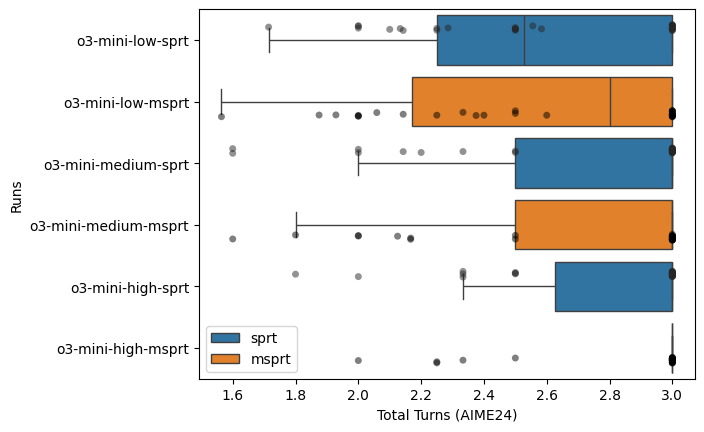

In [39]:
import re

# Combine the list of DataFrames
df_concat = pd.concat(df)

# Process the run labels:
# 1. Remove "-aime24"
df_concat["run"] = df_concat["run"].str.replace("-aime24", "", regex=False)
df_concat["run"] = df_concat["run"].str.replace("o3mini", "o3-mini-", regex=False)
# 2. Remove the numbers (and any extra characters) after "sprt" or "msprt"
df_concat["run"] = df_concat["run"].str.replace(r"(-(?:m)?sprt).*", r"\1", regex=True)

# Create the boxplot without fliers
ax = sns.boxplot(
    data=df_concat, y="run", x="Generations Per Turn", hue="model", showfliers=False
)

# Overlay with jittered points
sns.stripplot(
    data=df_concat,
    y="run",
    x="Generations Per Turn",
    hue="model",
    jitter=True,
    dodge=True,
    marker="o",
    color="black",
    alpha=0.5,
)

# Remove duplicate legends
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:len(handles)//2], labels[0:len(labels)//2])
plt.xlabel("Total Turns (AIME24)")
plt.ylabel("Runs")

plt.savefig("total_turns.pdf", bbox_inches='tight')
plt.show()
